In [2]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin,BaseEstimator
from datetime import datetime
from datetime import date
import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_palette("mako")

In [3]:
def find_outliers(data,column):
    data_mean, data_std=np.mean(data),np.std(data)
    cut_off=data_std*3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers=[x for x in data if x<lower or x >upper]
    print('Počet outlierov v stĺpci ' + column +  ' je %d' % len(outliers))

In [4]:
def findDiffCorrelation(tmp_data):
    return (tmp_data.iloc[: , :15].corr() - data.iloc[: , :15].corr()).max()

In [5]:
def transform_col(dataframe, column):
        quartil_down = dataframe[column].quantile(0.05)
        quartil_up = dataframe[column].quantile(0.95)
        
        for i, value in dataframe.iterrows():
            if value[column] < quartil_down:
                dataframe.loc[i, column] = quartil_down
            elif value[column] > quartil_up:
                dataframe.loc[i, column] = quartil_up
        return dataframe
def transform(dataframe):
    col_names= list(dataframe.columns.values)
    col_names = col_names[0:16]
    for column_name in col_names:
        transform_col(dataframe,column_name)
    return dataframe

### Načítanie a čistenie dát

In [6]:
stations= pd.read_csv("data/stations.csv", sep="\t")
measurements= pd.read_csv("data/measurements.csv", sep="\t")

In [7]:
measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12128 entries, 0 to 12127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       12080 non-null  float64
 1   PM10       12079 non-null  float64
 2   C2H3NO5    12079 non-null  float64
 3   O3         12079 non-null  float64
 4   NH3        12080 non-null  float64
 5   Pb         12079 non-null  float64
 6   PRES       12128 non-null  float64
 7   CFCs       12079 non-null  float64
 8   longitude  12128 non-null  float64
 9   SO2        12079 non-null  float64
 10  latitude   12128 non-null  float64
 11  NOx        12078 non-null  float64
 12  warning    12079 non-null  float64
 13  CO         12079 non-null  float64
 14  CH4        12079 non-null  float64
 15  PM2.5      12080 non-null  float64
 16  H2CO       12080 non-null  float64
 17  TEMP       12080 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


In [8]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    1051 non-null   object 
 1   latitude   1051 non-null   float64
 2   code       1050 non-null   object 
 3   revision   1051 non-null   object 
 4   QoS        1051 non-null   object 
 5   longitude  1051 non-null   float64
dtypes: float64(2), object(4)
memory usage: 49.4+ KB


Skontrolujeme, či sú jednotlivé 'latitude' jedinečné, a podľa nich joineme.

In [9]:
latitude_s = stations["latitude"].unique().sort()
latitude_m = measurements["latitude"].unique().sort()
np.array_equal(latitude_s, latitude_m)

True

Sú rovnaké, preto môžeme ich spojiť.
Odstránime QoS, revision a code, keďže tieto parametre neovplyvňujú kvalitu ovzdušia.Taktiež odstránime duplicitný stĺpec ktorý nám vznikne.

In [10]:
stations.drop(columns=["QoS"], inplace=True)
stations.drop(columns=["revision"], inplace=True)
stations.drop(columns=["code"], inplace=True)
data = pd.merge(measurements, stations, on = ["latitude"], how = "left")
data.drop(columns=["longitude_x"], inplace=True)
data.rename(columns={'longitude_y': 'longitude'}, inplace=True)
data_orig = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25540 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       25447 non-null  float64
 1   PM10       25437 non-null  float64
 2   C2H3NO5    25444 non-null  float64
 3   O3         25435 non-null  float64
 4   NH3        25448 non-null  float64
 5   Pb         25435 non-null  float64
 6   PRES       25540 non-null  float64
 7   CFCs       25447 non-null  float64
 8   SO2        25434 non-null  float64
 9   latitude   25540 non-null  float64
 10  NOx        25443 non-null  float64
 11  warning    25427 non-null  float64
 12  CO         25437 non-null  float64
 13  CH4        25442 non-null  float64
 14  PM2.5      25434 non-null  float64
 15  H2CO       25443 non-null  float64
 16  TEMP       25438 non-null  float64
 17  station    25540 non-null  object 
 18  longitude  25540 non-null  float64
dtypes: float64(18), object(1)
memory usage: 3.9+ M

Ukážka dát po spojení.

In [11]:
data.head()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,station,longitude
0,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
1,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
2,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
3,10.39372,8.25541,1.19707,8.98772,9.82297,47.15361,1063.43896,69.62954,8.29285,8.88649,10.26103,0.0,8.47772,9.60717,7.09990,65.37280,13.19832,Tchaourou,2.59753
4,9.56441,8.43278,1.32137,4.43270,8.08426,47.94224,1111.55551,77.84035,8.42276,10.10649,6.11983,1.0,8.97045,8.89398,8.22953,47.62991,3.92248,Alwaye,76.35484


Odstránime duplicitné záznamy

In [12]:
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 13591


In [13]:
data = data.drop_duplicates()
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 0


In [14]:
data = data.dropna()

In [15]:
data.describe()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,longitude
count,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000,11247.000000
mean,8.795834,8.794249,3.334245,9.315605,8.806920,49.822809,1125.461488,72.099248,8.815208,28.520028,9.320864,0.595359,8.801879,9.307192,8.779193,50.764902,14.927524,8.816153
std,2.071918,0.991567,4.061859,1.906820,0.994988,12.762958,43.276445,7.175351,1.937885,23.409862,1.690273,0.490844,1.003237,1.903903,2.082461,13.920511,9.969673,72.886561
min,1.925340,5.187260,0.000000,2.048720,5.124910,0.000000,1050.000710,0.000000,1.029620,-54.800000,2.304540,0.000000,5.032870,2.492000,0.000000,0.000000,-26.219360,-156.474320
25%,7.341205,8.128660,1.196050,8.122940,8.131975,41.275425,1087.995975,67.280520,7.426945,13.701670,8.392010,0.000000,8.127460,8.032165,7.302695,41.479690,8.165560,-65.614270
50%,8.856880,8.791270,2.126810,9.479370,8.809170,49.715720,1126.187440,72.170840,8.987330,36.215440,9.642420,1.000000,8.811630,9.422650,8.626520,50.682620,14.906580,7.360270
75%,10.275880,9.461760,3.930685,10.660155,9.467410,58.387905,1162.776605,76.922500,10.210685,45.040800,10.487195,1.000000,9.477765,10.642780,10.260215,60.127185,21.712495,69.013540
max,17.068470,12.750440,100.000000,15.619060,12.763030,100.000000,1199.974700,100.000000,15.572620,68.798330,14.915300,1.000000,12.576710,16.569680,16.646230,100.000000,48.555180,178.004170


Presunieme si latitude a longtitude na koniec, aby sme vedeli neskôr ľahšie vyberať parametre ovplyvňujúce kvalitu ovzdušia.

In [16]:
data.insert(16, 'latitude', data.pop('latitude'))
data.insert(17, 'longitude', data.pop('longitude'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11247 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       11247 non-null  float64
 1   PM10       11247 non-null  float64
 2   C2H3NO5    11247 non-null  float64
 3   O3         11247 non-null  float64
 4   NH3        11247 non-null  float64
 5   Pb         11247 non-null  float64
 6   PRES       11247 non-null  float64
 7   CFCs       11247 non-null  float64
 8   SO2        11247 non-null  float64
 9   NOx        11247 non-null  float64
 10  warning    11247 non-null  float64
 11  CO         11247 non-null  float64
 12  CH4        11247 non-null  float64
 13  PM2.5      11247 non-null  float64
 14  H2CO       11247 non-null  float64
 15  TEMP       11247 non-null  float64
 16  latitude   11247 non-null  float64
 17  longitude  11247 non-null  float64
 18  station    11247 non-null  object 
dtypes: float64(18), object(1)
memory usage: 1.7+ M

### Odstránenie NA hodnôt
Ako prvé skúsime metódu s odstránením riadkov, kde chýbajú hodnoty.

In [17]:
tmp_data = data.copy()
tmp_data.dropna(inplace=True)

In [18]:
len(data) - len(tmp_data)

0

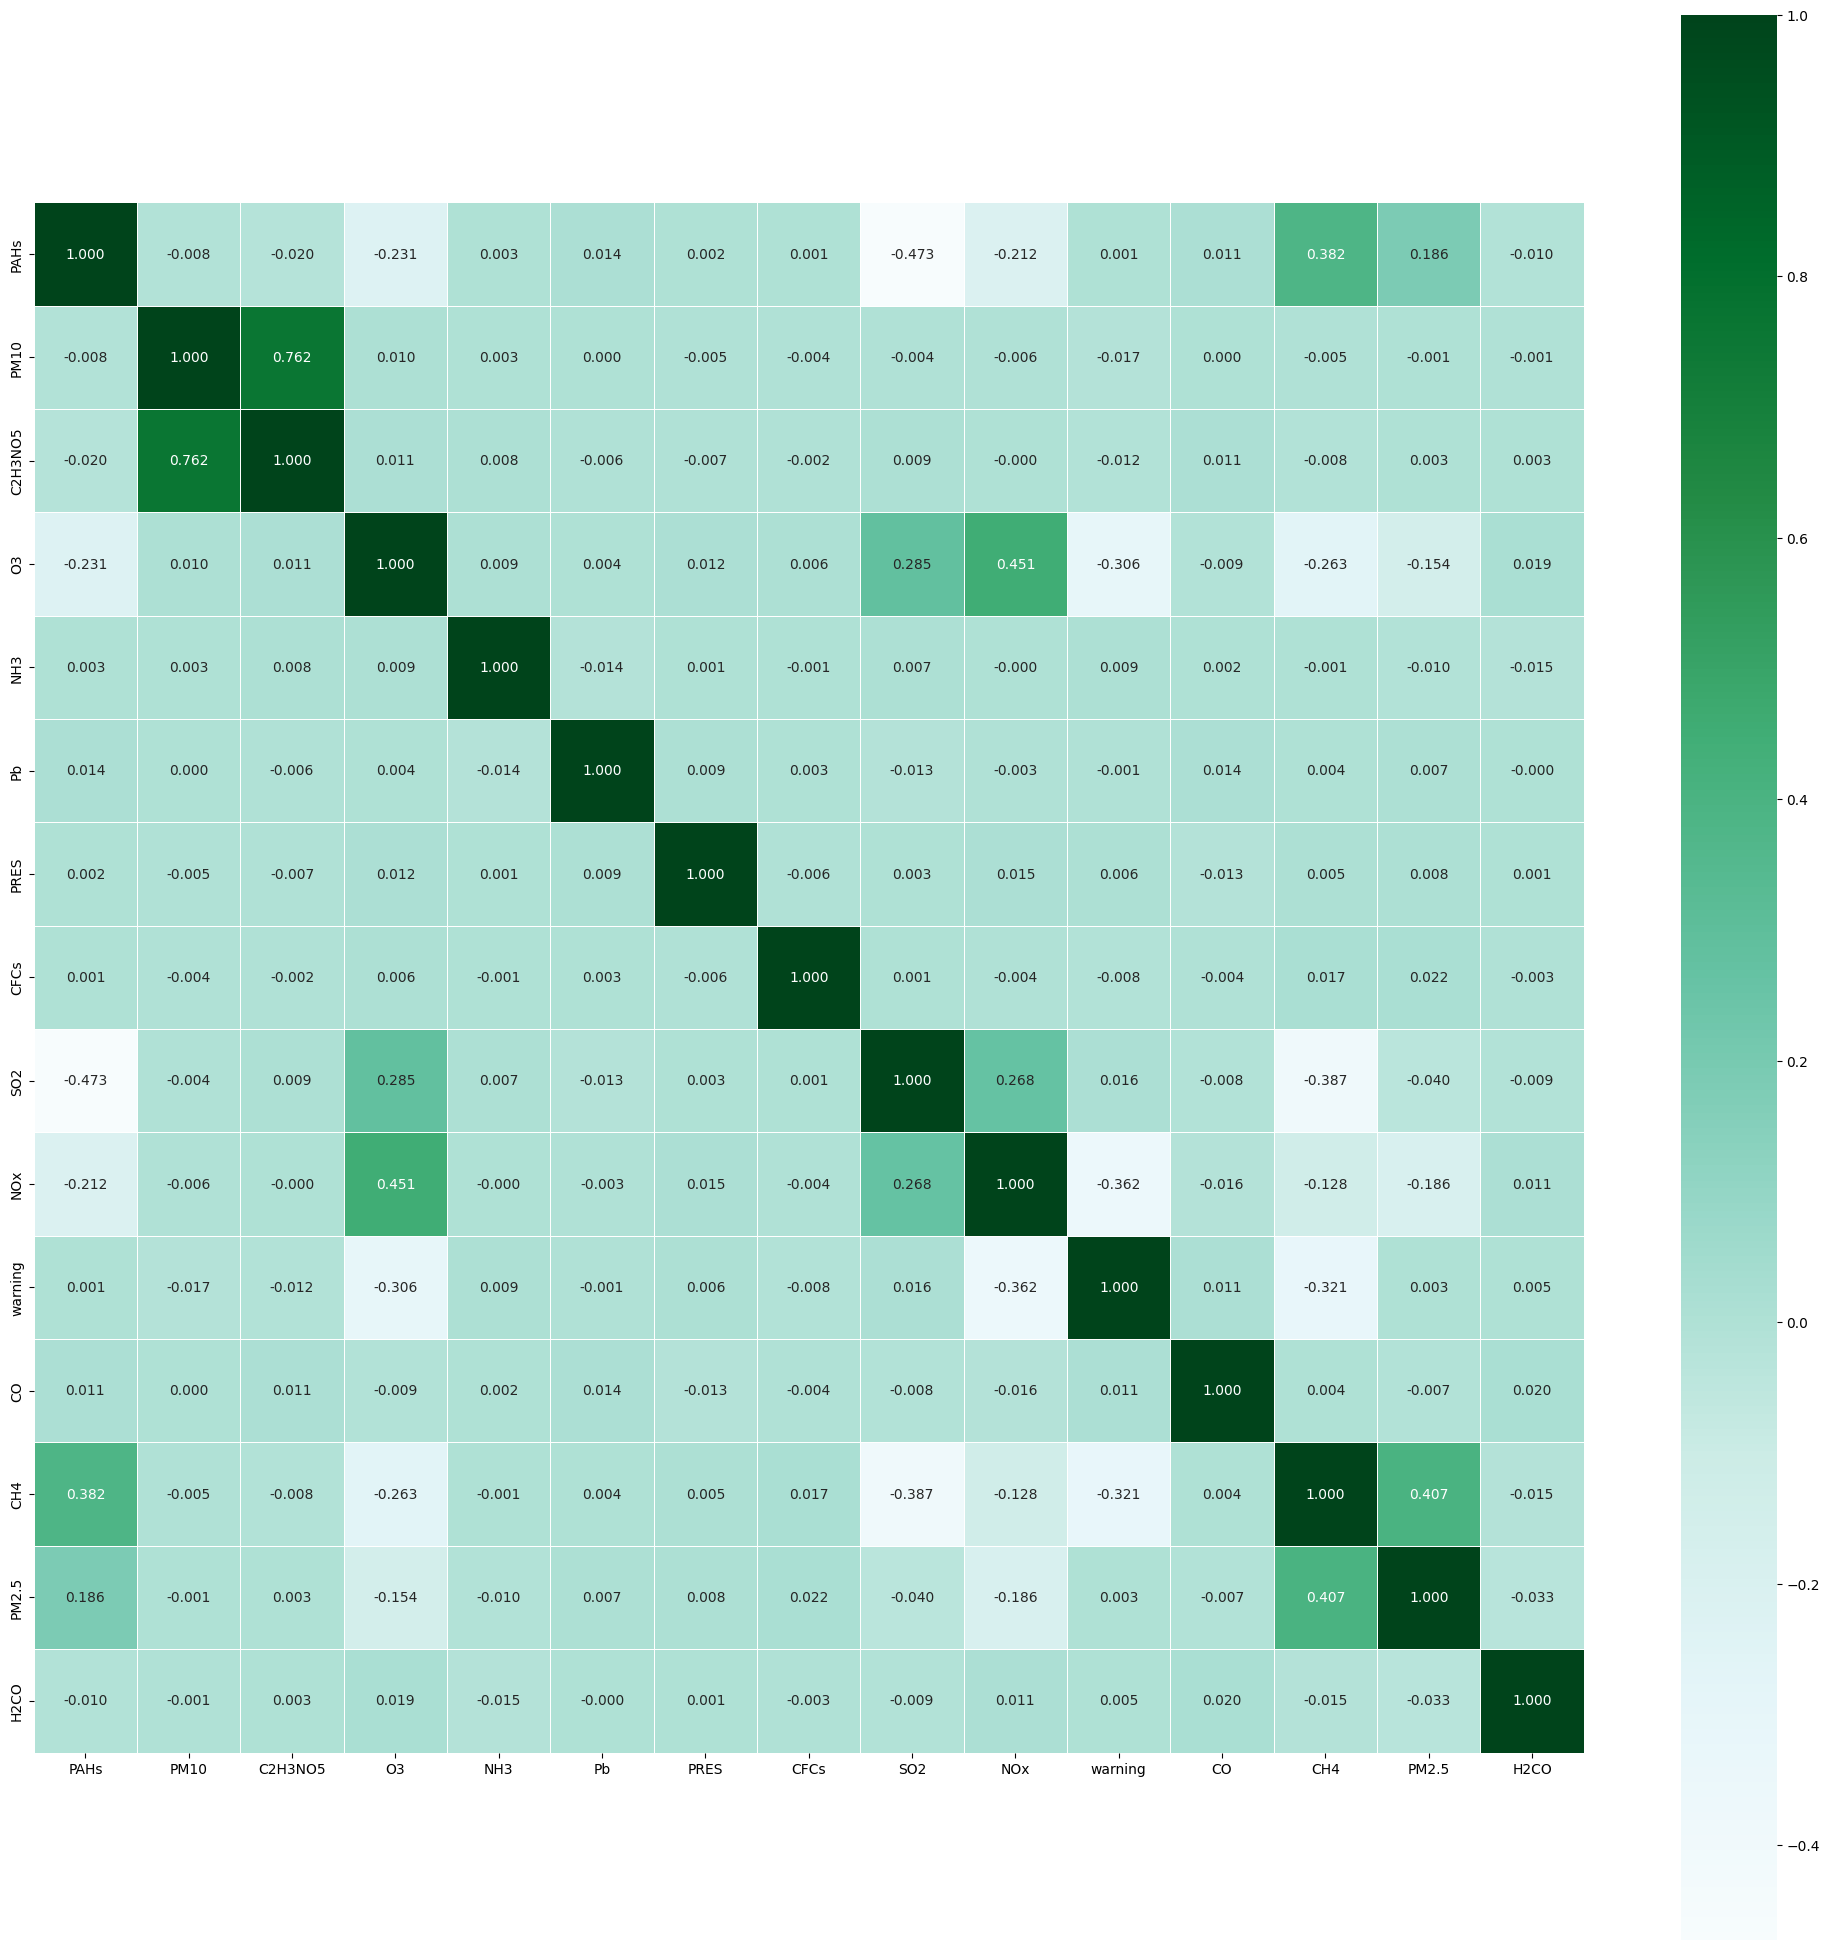

In [19]:
plt.figure(figsize=(25,25))
sns.heatmap(data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

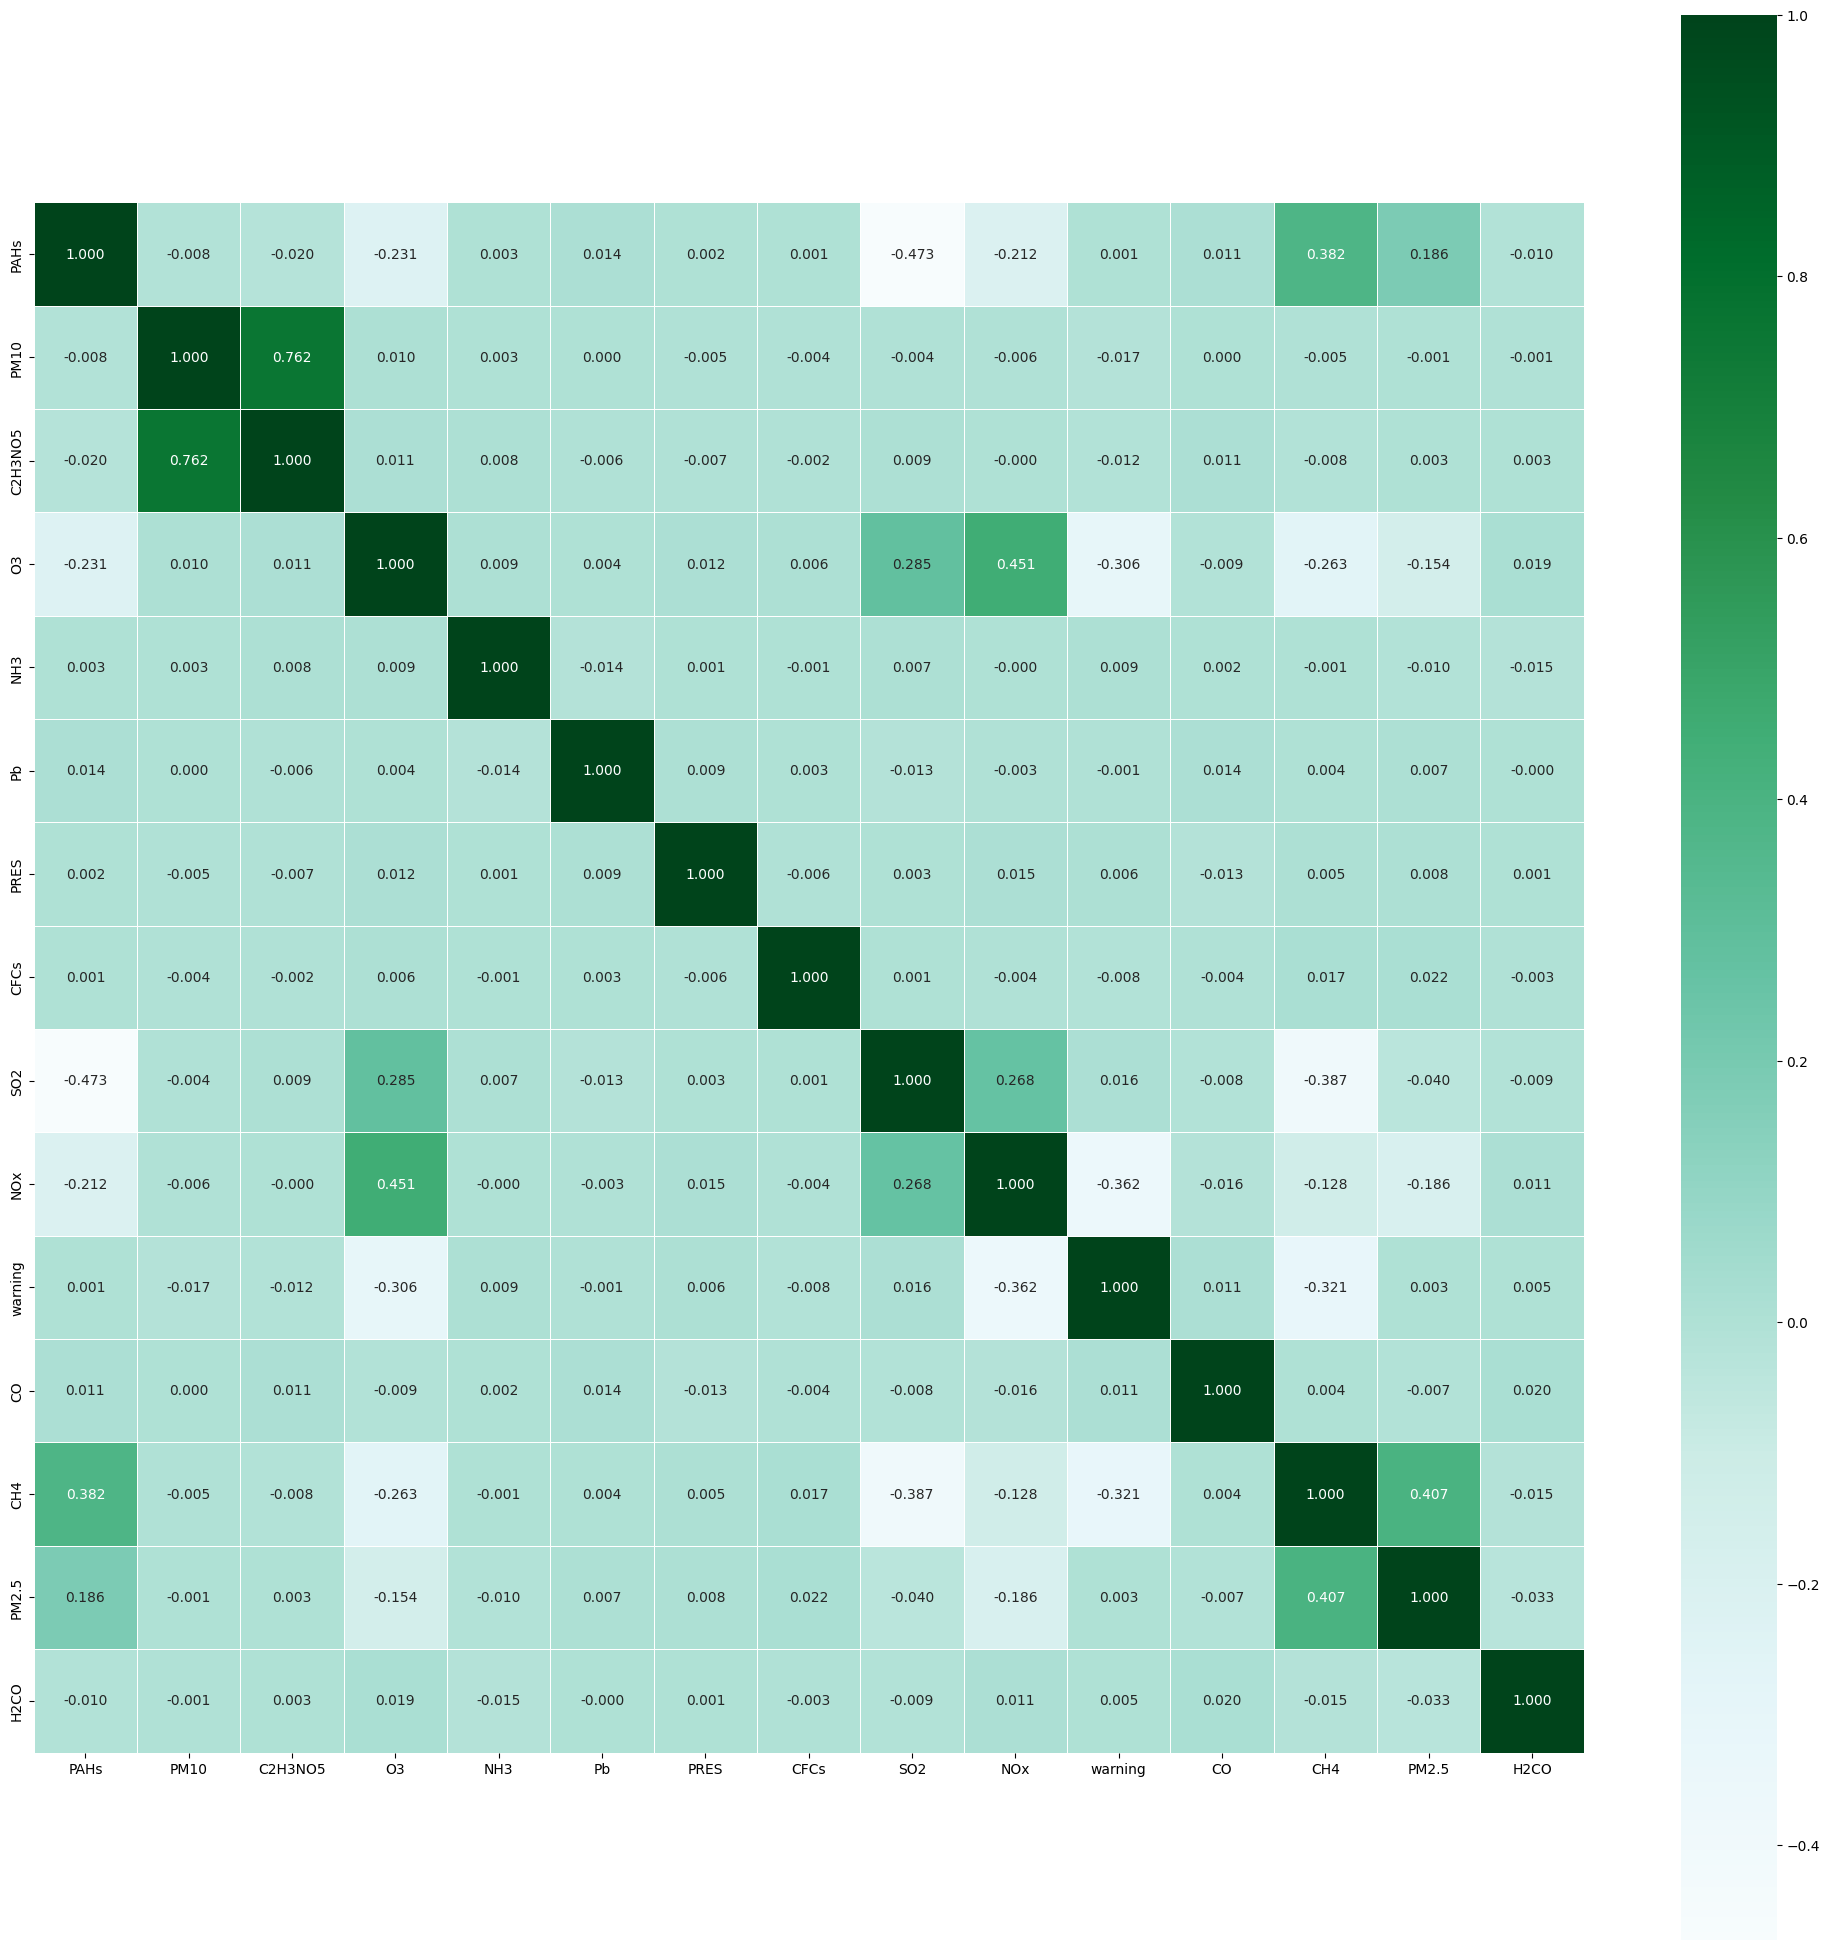

In [20]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Výpočet korelácie metódou zmananím.

In [21]:
findDiffCorrelation(tmp_data)

PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Výhodou tohto prístupu je, že sa nám heatmapa zmenila len minimálne. Nevýhodou je, že nám zmizlo 702 záznamov.
To nám predstavuje 5.87% dát.

In [22]:
(len(data)-len(tmp_data))/(len(data)) * 100

0.0

2. metóda je nahradenie N/A hodnôt mediánom 

In [23]:
temp_data_median = data.copy()
temp_data_median.fillna(temp_data_median.iloc[: , :15].median(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom")
findDiffCorrelation(temp_data_median)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

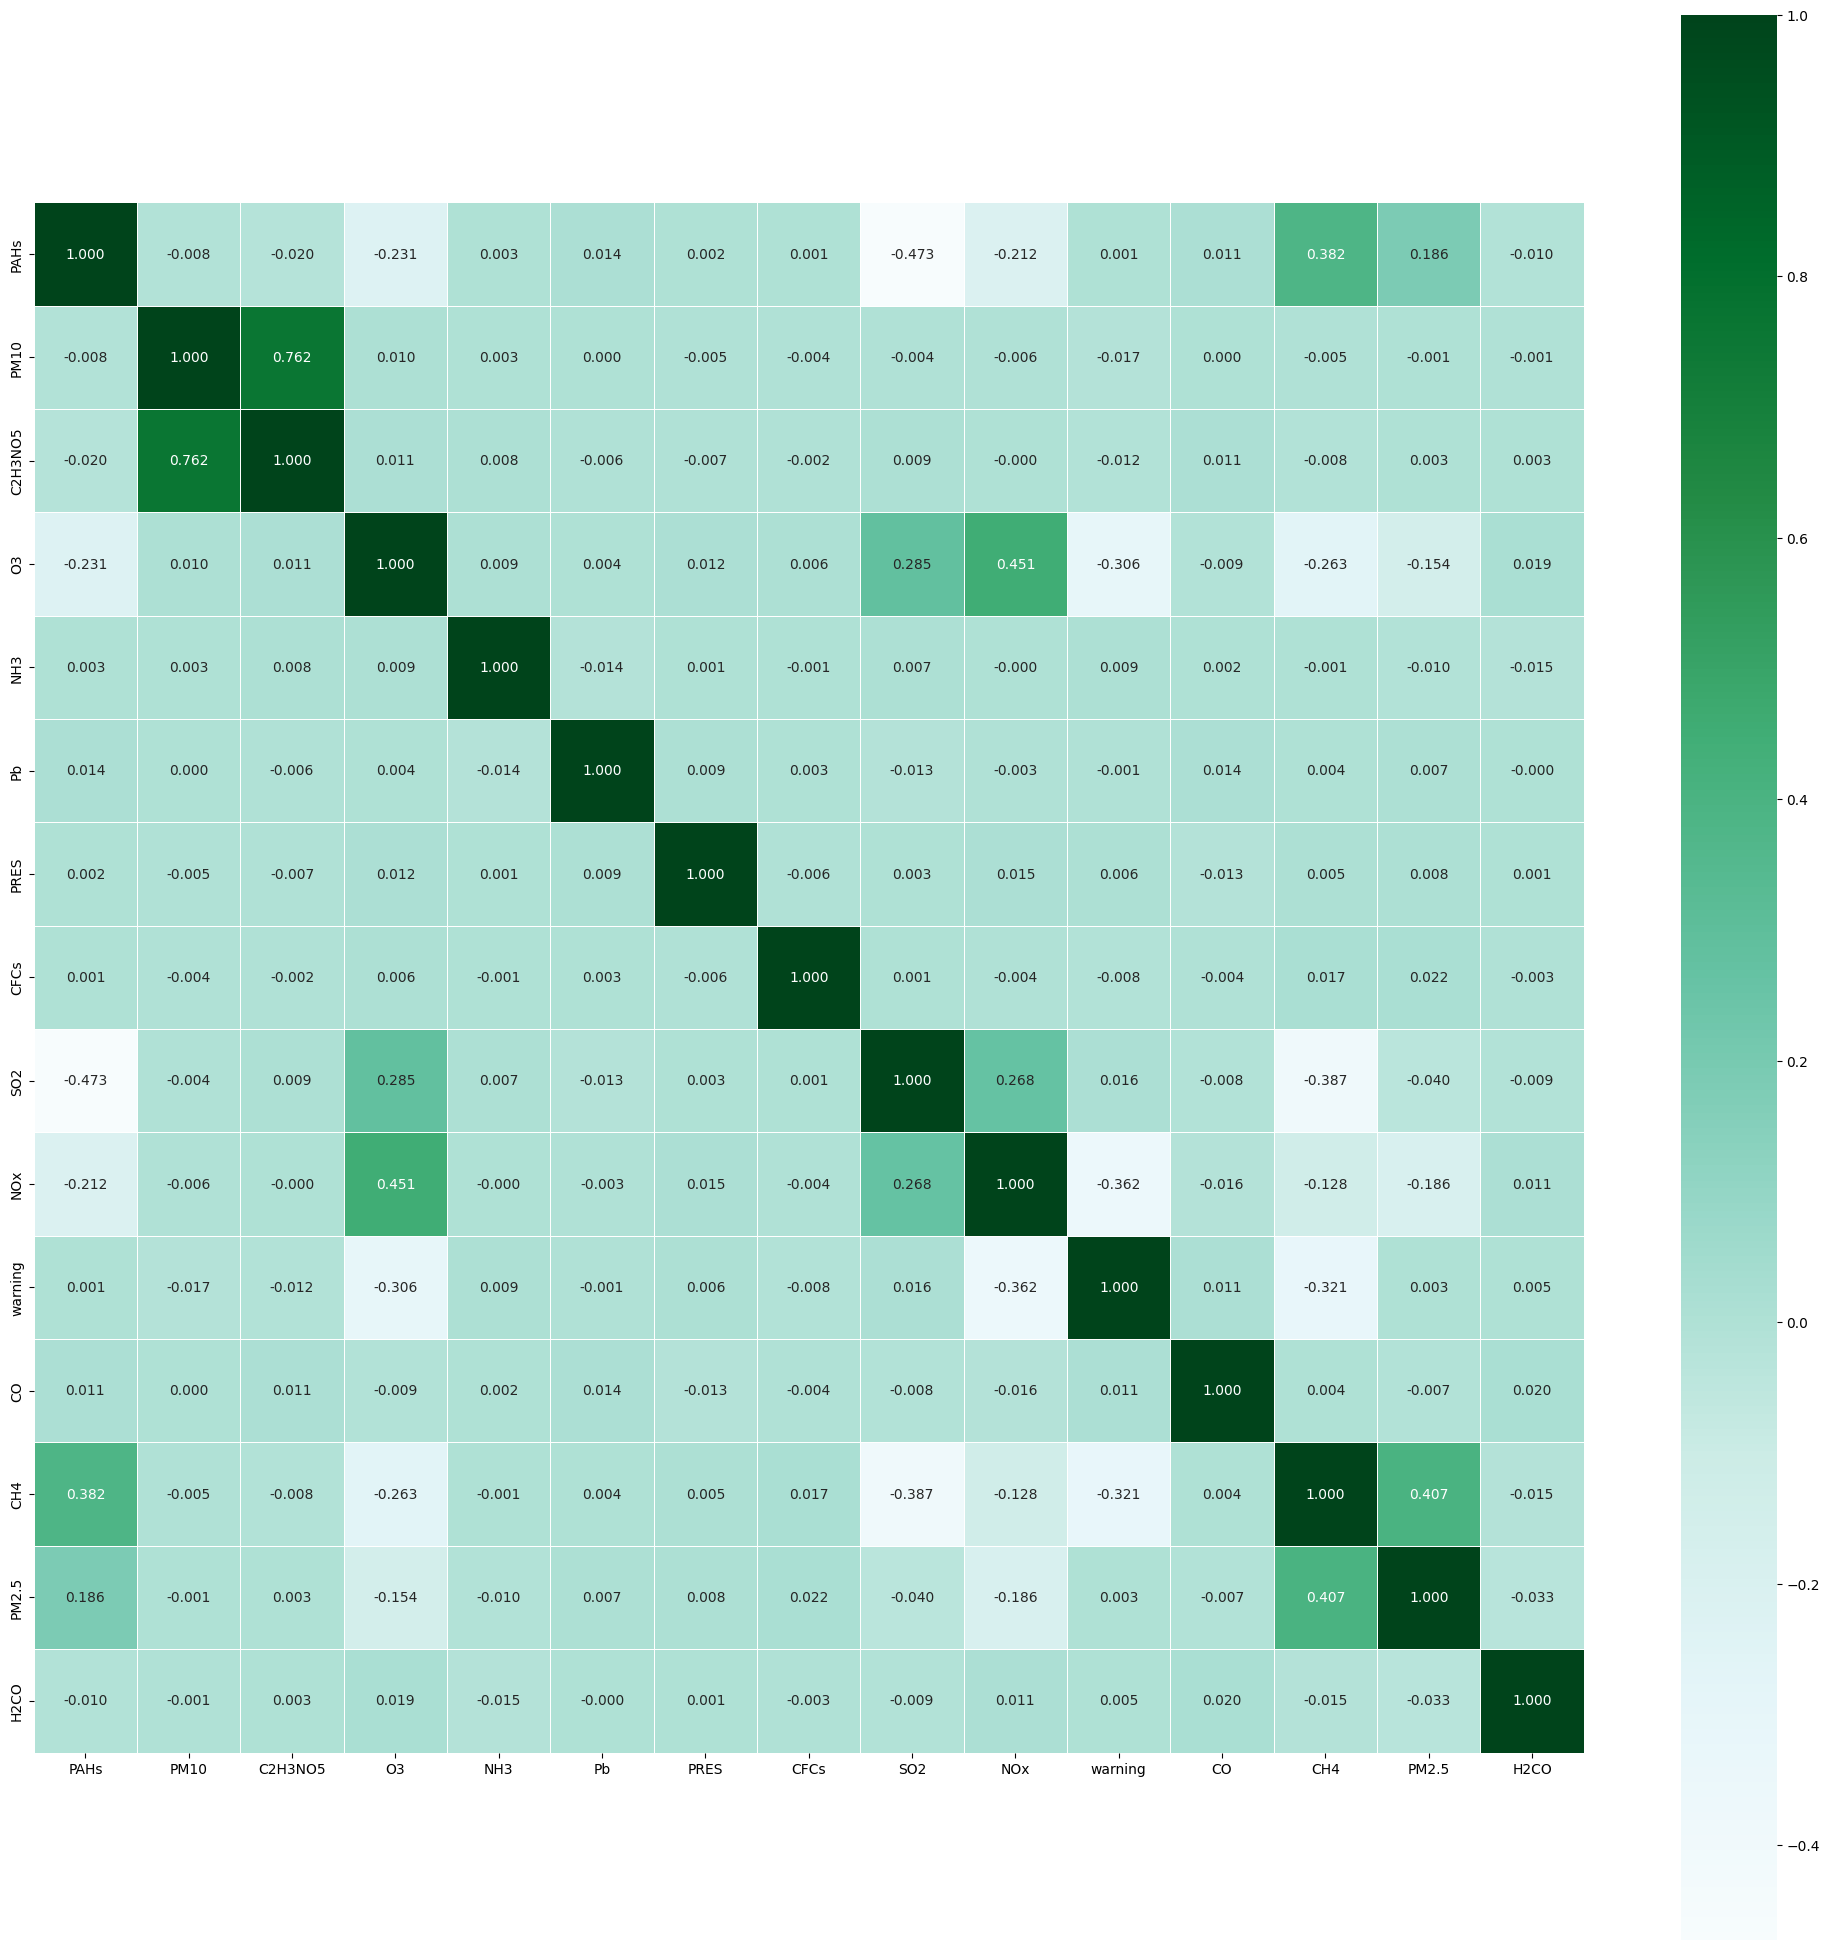

In [24]:
plt.figure(figsize=(25,25))
sns.heatmap(temp_data_median.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

3.Nahradenie chýbajúcich hodnôt priemerom


In [25]:
tmp_data_average = data.copy()
tmp_data_average.fillna(tmp_data_average.iloc[: , :1].mean(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom")
findDiffCorrelation(tmp_data_average)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

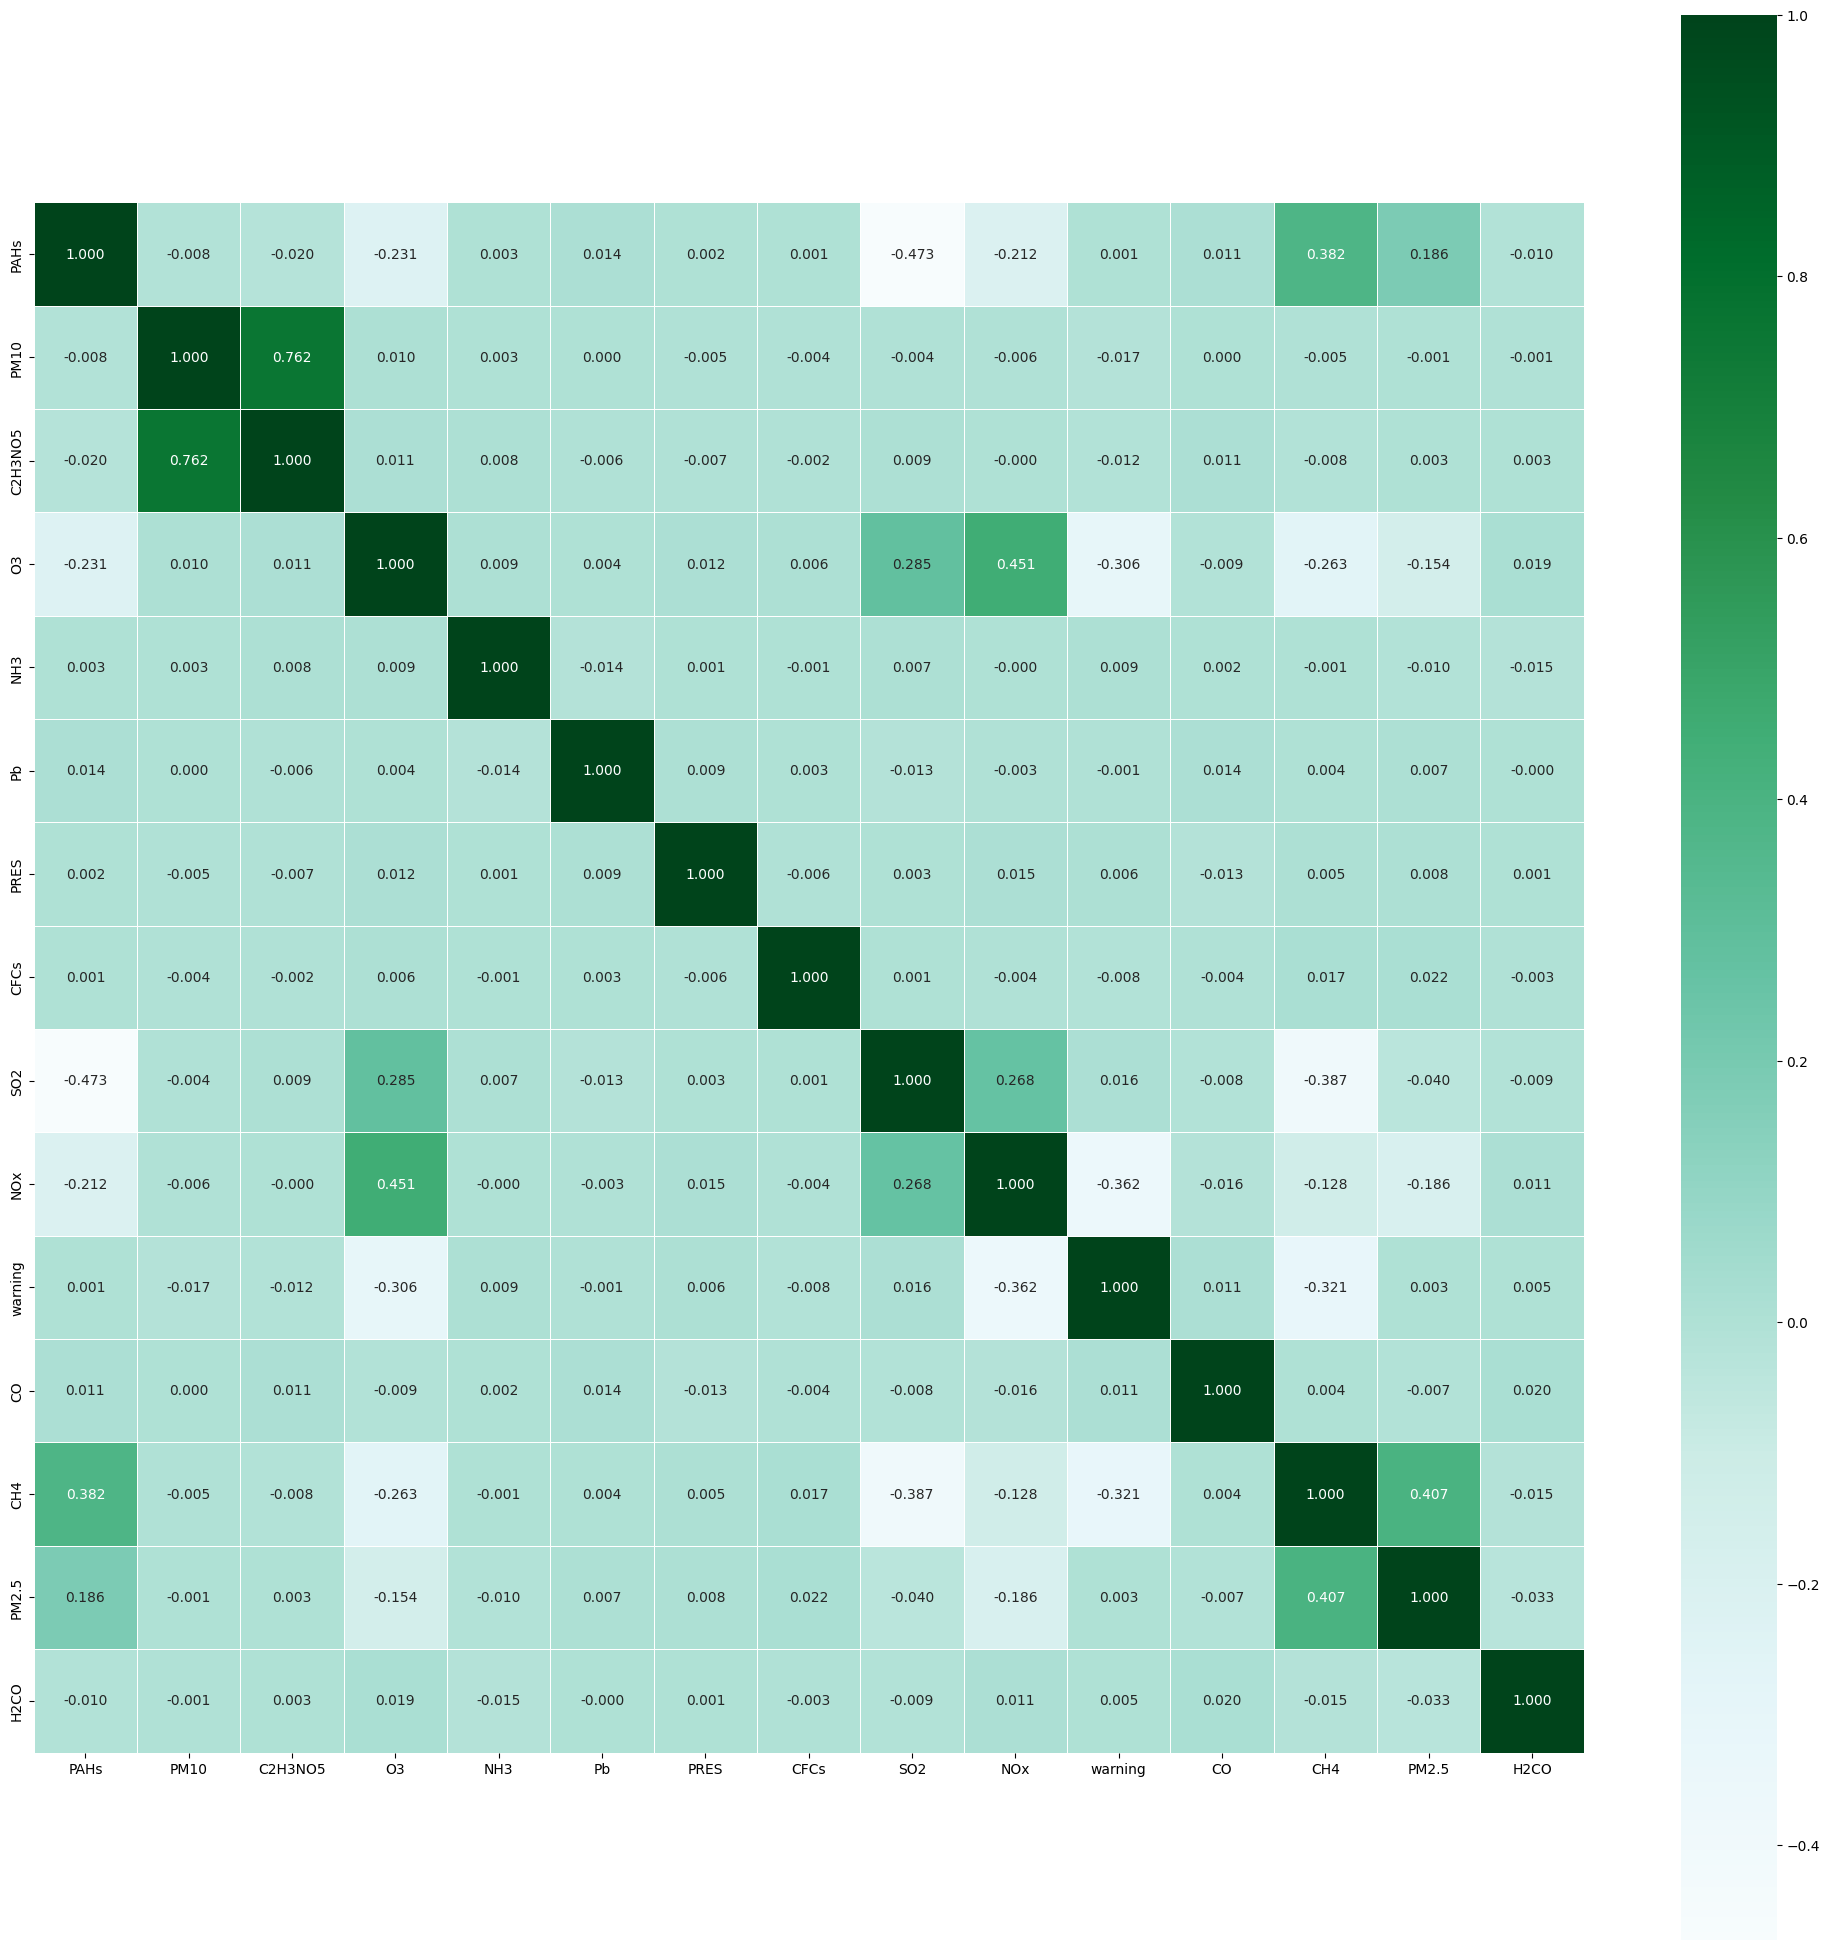

In [26]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_average.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

In [27]:
tmp_data_knn = data.copy()
imputer = KNNImputer(n_neighbors=2)
tmp_data_measurements = tmp_data_knn.iloc[:, :15]
tmp_data_measurements = imputer.fit_transform(tmp_data_measurements)
tmp_data_knn.iloc[:, :15] = tmp_data_measurements
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN")
findDiffCorrelation(tmp_data_knn)


Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

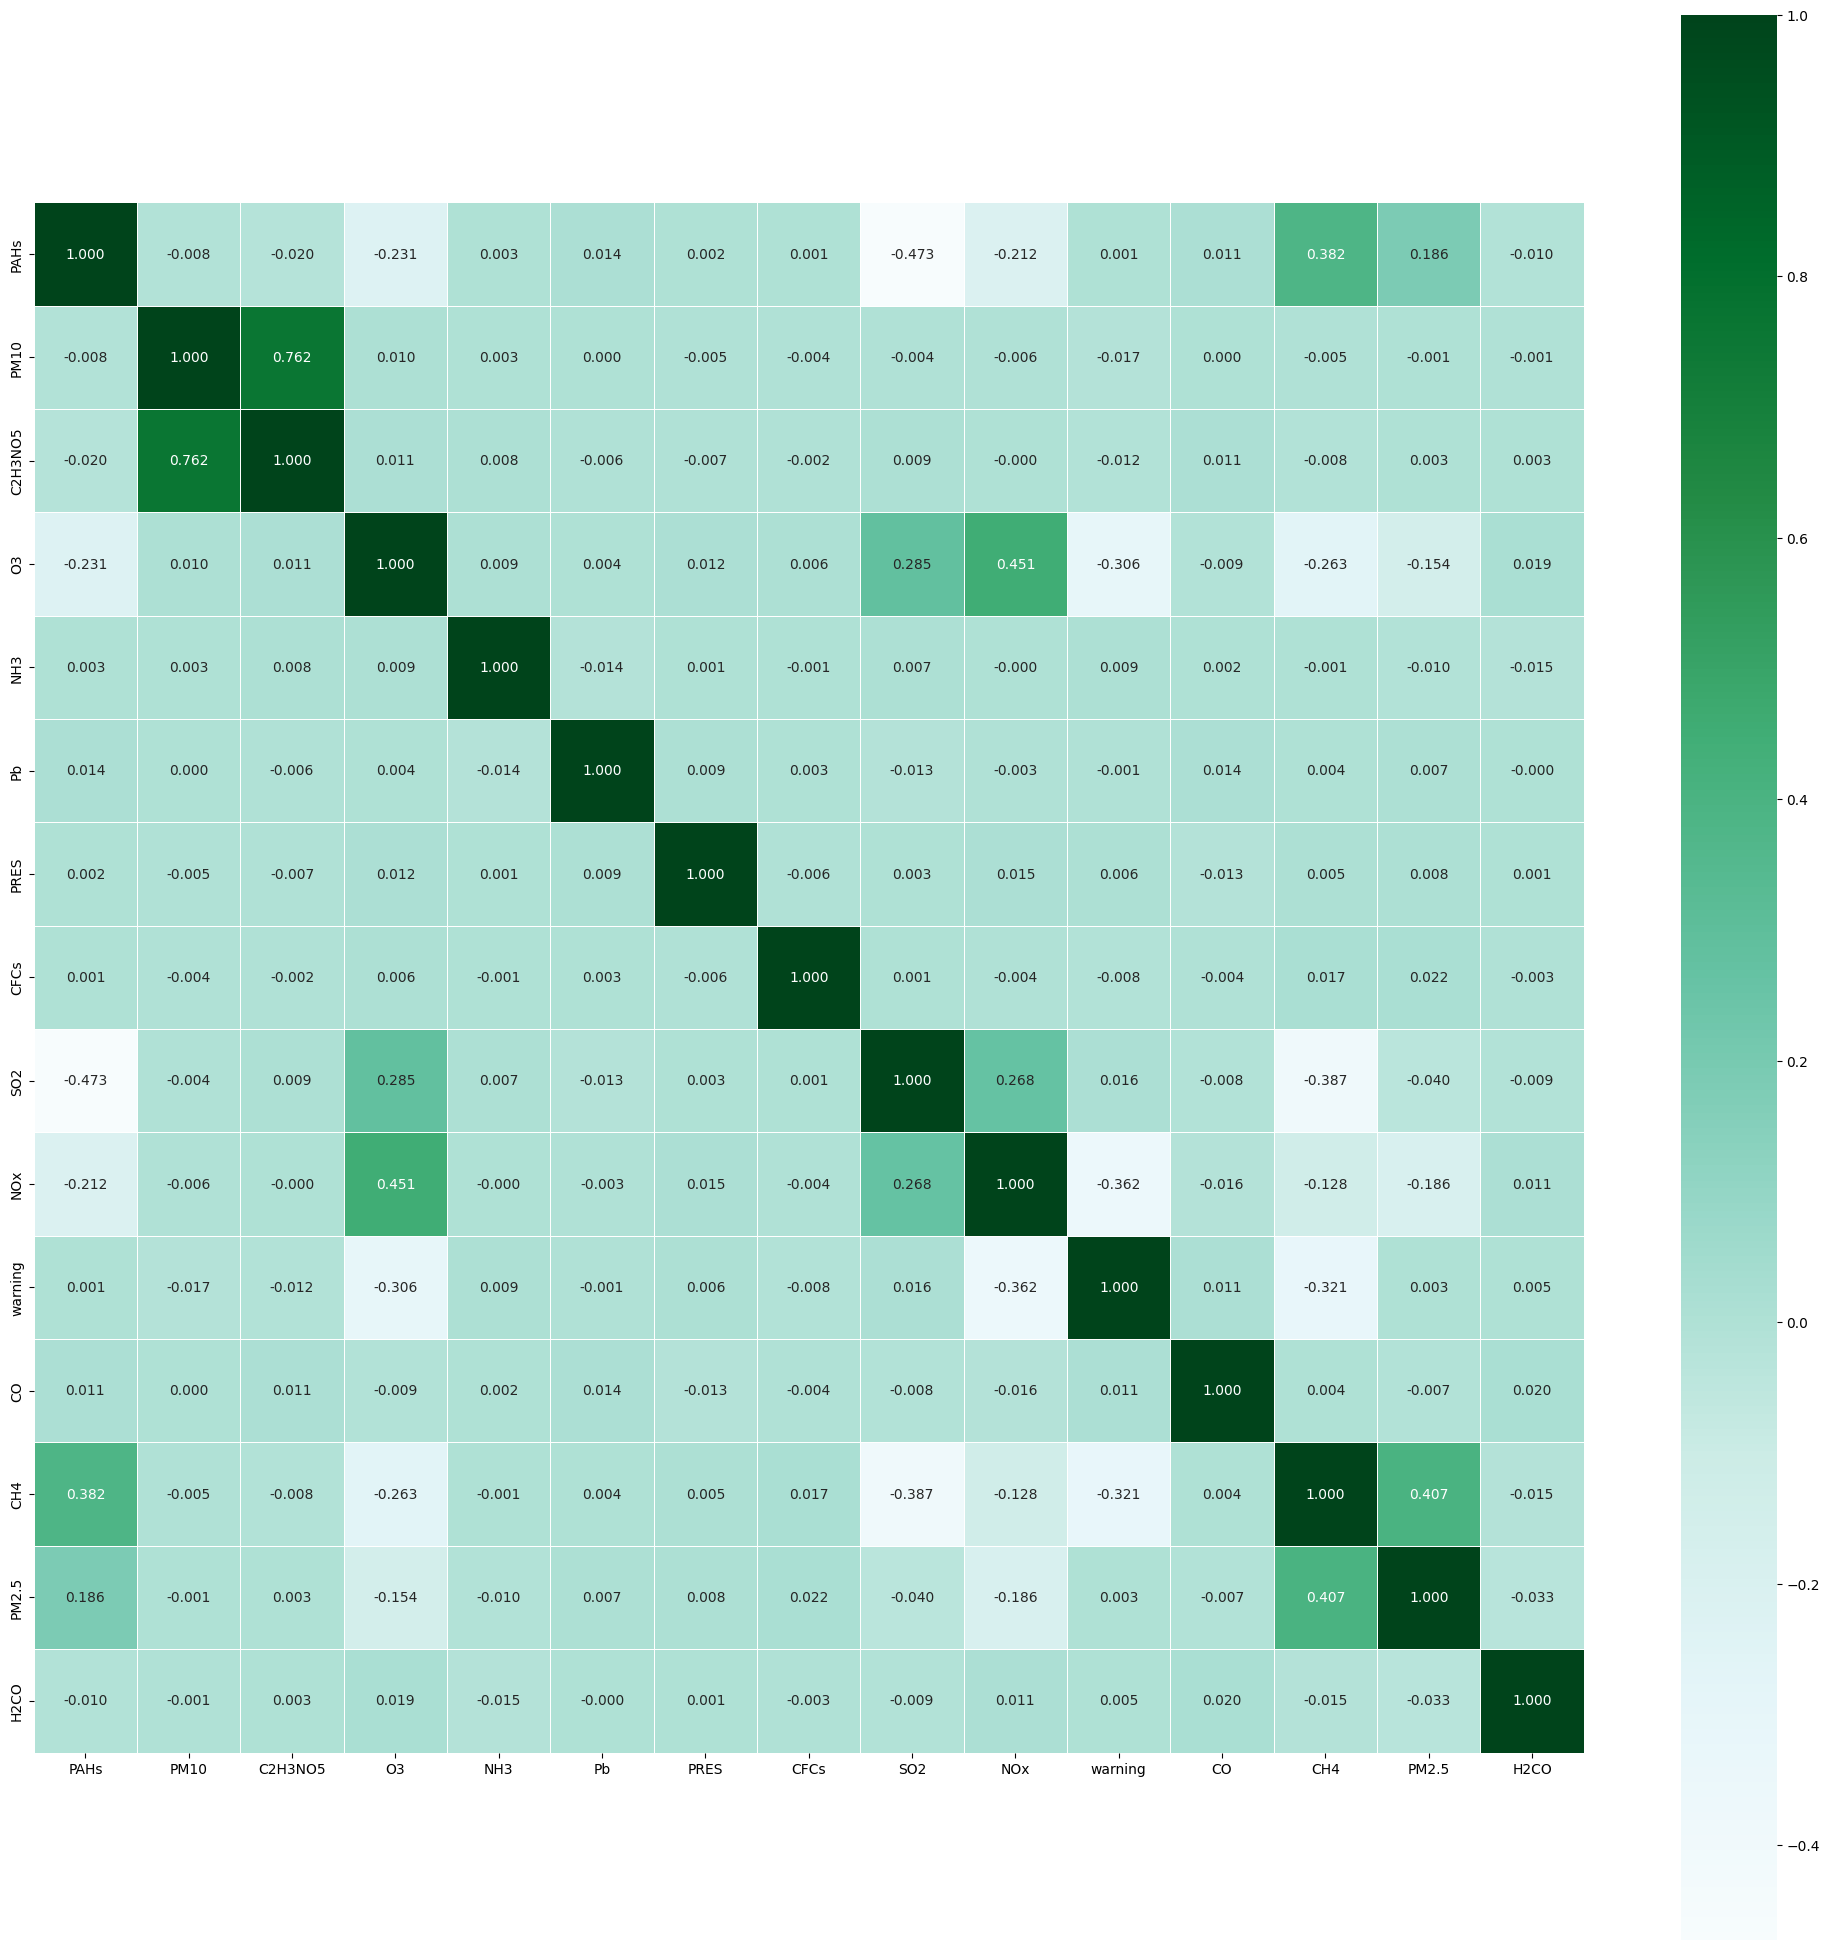

In [28]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_knn.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Nájdeme, ktorá z metód bola najefektívnejšia

In [29]:
diff_corr_median = abs(temp_data_median.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_average = abs(tmp_data_average.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_knn = abs(tmp_data_knn.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
print("Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom: ", diff_corr_median)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom: ", diff_corr_average)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN: ",diff_corr_knn)
listik = [diff_corr_median,diff_corr_average,diff_corr_knn]
print("Najmenšia odchýlka je:",min(listik))
  

Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom:  0.0
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom:  0.0
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN:  0.0
Najmenšia odchýlka je: 0.0


Z priemerových odchýliek vidíme, že najlepšie pre nás bude použiť nahradenie hodnôt priemerom.   

In [30]:
data = tmp_data_average.copy()

### Odstránenie vychýlených hodnôt (outlierov)

In [31]:
for column in data.describe().columns:
    find_outliers(data[column],column)

Počet outlierov v stĺpci PAHs je 20
Počet outlierov v stĺpci PM10 je 28
Počet outlierov v stĺpci C2H3NO5 je 202
Počet outlierov v stĺpci O3 je 35
Počet outlierov v stĺpci NH3 je 29
Počet outlierov v stĺpci Pb je 30
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 30
Počet outlierov v stĺpci SO2 je 22
Počet outlierov v stĺpci NOx je 54
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 30
Počet outlierov v stĺpci CH4 je 16
Počet outlierov v stĺpci PM2.5 je 21
Počet outlierov v stĺpci H2CO je 24
Počet outlierov v stĺpci TEMP je 24
Počet outlierov v stĺpci latitude je 42
Počet outlierov v stĺpci longitude je 0


Skopírujeme si dáta, aby sme vedeli vykonávať testy a nemenili sme priamo naše dáta.

In [32]:
tmp_data = data.copy()

In [33]:
transform(tmp_data)

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,latitude,longitude,station
0,7.22628,9.070790,2.63533,9.956520,9.218640,29.988020,1093.161570,67.383610,9.896820,10.31364,0.0,8.368100,9.75090,10.197320,59.16382,1.58478,-5.85746,144.23058,Mount Hagen
3,10.39372,8.255410,1.19707,8.987720,9.822970,47.153610,1063.438960,69.629540,8.292850,10.26103,0.0,8.477720,9.60717,7.099900,65.37280,13.19832,8.88649,2.59753,Tchaourou
4,9.56441,8.432780,1.32137,5.894679,8.084260,47.942240,1111.555510,77.840350,8.422760,6.11983,1.0,8.970450,8.89398,8.229530,47.62991,3.92248,10.10649,76.35484,Alwaye
7,10.78799,9.806910,5.28964,6.234200,8.382040,70.864838,1156.281810,60.293215,5.842520,8.65345,1.0,7.143903,11.94774,9.474080,68.73458,18.35811,-37.32167,-59.13316,Tandil
11,5.64192,9.361080,3.44736,12.022130,8.937780,45.687780,1185.273020,67.192460,11.775533,10.49590,1.0,9.067820,6.62910,6.625910,56.52691,30.99446,42.22718,14.39024,Lanciano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25527,11.86566,7.547250,0.93197,8.971060,8.125680,70.864838,1123.939440,63.237190,7.381750,9.18056,1.0,7.729360,8.43387,12.291386,48.73235,22.93622,43.61092,3.87723,Montpellier
25531,7.68875,9.535790,4.26800,9.413410,7.170227,28.650028,1192.803094,65.513060,10.008210,9.28442,0.0,7.487370,8.58958,7.855470,45.55913,15.71239,21.53889,71.57737,Gariadhar
25534,7.99479,9.646130,4.78692,10.148720,9.237720,66.960970,1167.874010,69.358600,9.394190,9.82530,0.0,8.519670,10.46974,10.769340,47.86523,27.31949,60.02427,30.28491,Kolomyagi
25536,7.66997,9.331370,3.46029,10.384170,9.977970,41.852620,1134.353010,63.387570,9.835230,9.77990,0.0,8.732990,9.86713,10.521820,62.45908,17.54827,39.59611,27.02444,Edremit


In [34]:
for column in data.describe().columns:
    find_outliers(tmp_data[column],column)

Počet outlierov v stĺpci PAHs je 0
Počet outlierov v stĺpci PM10 je 0
Počet outlierov v stĺpci C2H3NO5 je 0
Počet outlierov v stĺpci O3 je 0
Počet outlierov v stĺpci NH3 je 0
Počet outlierov v stĺpci Pb je 0
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 0
Počet outlierov v stĺpci SO2 je 0
Počet outlierov v stĺpci NOx je 0
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 0
Počet outlierov v stĺpci CH4 je 0
Počet outlierov v stĺpci PM2.5 je 0
Počet outlierov v stĺpci H2CO je 0
Počet outlierov v stĺpci TEMP je 0
Počet outlierov v stĺpci latitude je 42
Počet outlierov v stĺpci longitude je 0


Ako vidíme, tak outlierov nám to úspešne odstránilo. Pri latitude a longitude outlierov neriešime - toto sú súradnice stanice.

In [35]:
tmp_data = data.copy()

UKRADNUTE OD SKURLIHO A NEFUNGUJE - KLASIKA

Škurli here - FUNGUJE TO LEN SI DEMENT A MAL SI NA HODNOTY, TO TU UZ ALE NENAPISES

In [36]:
z_scores = stats.zscore(tmp_data.iloc[:,:16]) 
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores <= 3).all(axis=1)
tmp_data = tmp_data[filtered_entries]
print(tmp_data)

           PAHs     PM10  C2H3NO5        O3      NH3        Pb        PRES  \
0       7.22628  9.07079  2.63533   9.95652  9.21864  29.98802  1093.16157   
3      10.39372  8.25541  1.19707   8.98772  9.82297  47.15361  1063.43896   
4       9.56441  8.43278  1.32137   4.43270  8.08426  47.94224  1111.55551   
7      10.78799  9.80691  5.28964   6.23420  8.38204  72.85236  1156.28181   
11      5.64192  9.36108  3.44736  12.02213  8.93778  45.68778  1185.27302   
...         ...      ...      ...       ...      ...       ...         ...   
25527  11.86566  7.54725  0.93197   8.97106  8.12568  74.87950  1123.93944   
25531   7.68875  9.53579  4.26800   9.41341  6.11207  25.79962  1194.52692   
25534   7.99479  9.64613  4.78692  10.14872  9.23772  66.96097  1167.87401   
25536   7.66997  9.33137  3.46029  10.38417  9.97797  41.85262  1134.35301   
25539   6.09774  6.50756  0.36799   7.84105  9.76842  23.67090  1169.72651   

           CFCs       SO2       NOx  warning       CO       CH4

In [37]:
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10711 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       10711 non-null  float64
 1   PM10       10711 non-null  float64
 2   C2H3NO5    10711 non-null  float64
 3   O3         10711 non-null  float64
 4   NH3        10711 non-null  float64
 5   Pb         10711 non-null  float64
 6   PRES       10711 non-null  float64
 7   CFCs       10711 non-null  float64
 8   SO2        10711 non-null  float64
 9   NOx        10711 non-null  float64
 10  warning    10711 non-null  float64
 11  CO         10711 non-null  float64
 12  CH4        10711 non-null  float64
 13  PM2.5      10711 non-null  float64
 14  H2CO       10711 non-null  float64
 15  TEMP       10711 non-null  float64
 16  latitude   10711 non-null  float64
 17  longitude  10711 non-null  float64
 18  station    10711 non-null  object 
dtypes: float64(18), object(1)
memory usage: 1.6+ M

In [38]:
for column in data.describe().columns:
    find_outliers(tmp_data[column],column)

Počet outlierov v stĺpci PAHs je 1
Počet outlierov v stĺpci PM10 je 5
Počet outlierov v stĺpci C2H3NO5 je 244
Počet outlierov v stĺpci O3 je 4
Počet outlierov v stĺpci NH3 je 4
Počet outlierov v stĺpci Pb je 8
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 7
Počet outlierov v stĺpci SO2 je 0
Počet outlierov v stĺpci NOx je 19
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 3
Počet outlierov v stĺpci CH4 je 2
Počet outlierov v stĺpci PM2.5 je 5
Počet outlierov v stĺpci H2CO je 8
Počet outlierov v stĺpci TEMP je 3
Počet outlierov v stĺpci latitude je 40
Počet outlierov v stĺpci longitude je 0


##  Realizácia predspracovania dát
Rozdelenie na trénovaciu a testovaciu sadu 

In [43]:
training_data, test_data = train_test_split(tmp_data, test_size=0.2, random_state=42)
 

Pripravenie trénovacieho setu na strojové učenie  

In [62]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 5870 to 5719
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       14 non-null     float64
 1   PM10       14 non-null     float64
 2   C2H3NO5    14 non-null     float64
 3   O3         14 non-null     float64
 4   NH3        14 non-null     float64
 5   Pb         14 non-null     float64
 6   PRES       14 non-null     float64
 7   CFCs       14 non-null     float64
 8   SO2        14 non-null     float64
 9   NOx        14 non-null     float64
 10  warning    14 non-null     float64
 11  CO         14 non-null     float64
 12  CH4        14 non-null     float64
 13  PM2.5      14 non-null     float64
 14  H2CO       14 non-null     float64
 15  TEMP       14 non-null     float64
 16  latitude   14 non-null     float64
 17  longitude  14 non-null     float64
 18  station    14 non-null     object 
dtypes: float64(18), object(1)
memory usage: 2.2+ KB

Vytvoríme grafy podľa stĺpcov, pre ktoré sme tvorili hypotézy, pretože je tam vysoká šanca, že sa zobrazia vysoké hodnoty "warning"    

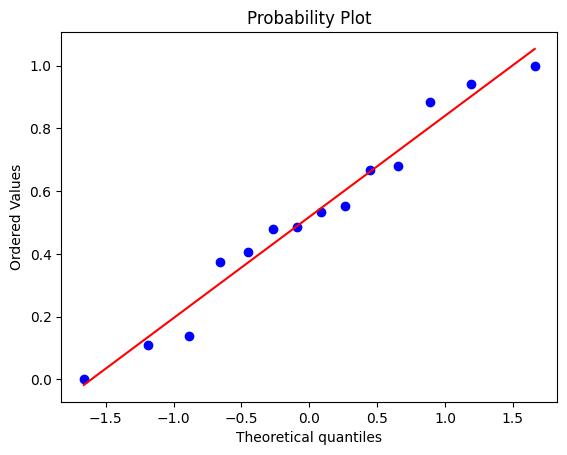

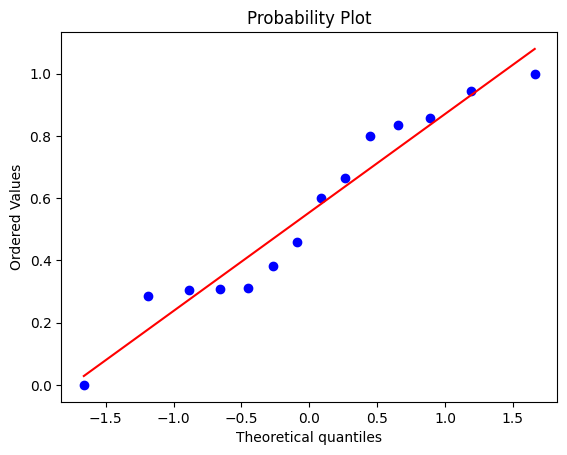

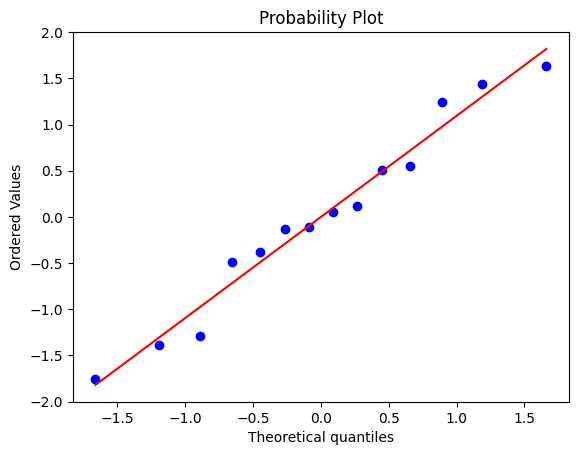

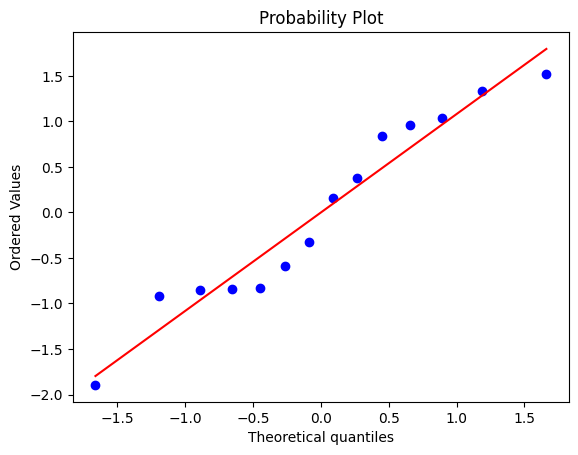

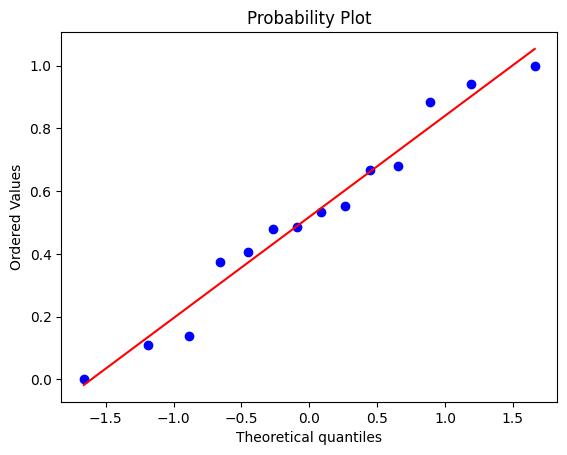

PAHs
PM10
O3
NH3
Pb
SO2
NOx
CO
PM2.5


c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
# Show columns
training_data.columns



stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

stats.probplot(training_data["NOx"], plot=sns.mpl.pyplot, fit=True)
plt.show()

# Using PowerTransformer to normalize data
pt = PowerTransformer()
training_data.iloc[:, :16] = pt.fit_transform(training_data.iloc[:, :16])
test_data.iloc[:, :16] = pt.transform(test_data.iloc[:, :16])

stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

stats.probplot(training_data["NOx"], plot=sns.mpl.pyplot, fit=True)
plt.show()

# Using MinMaxScaler to normalize data
scaler = MinMaxScaler()
training_data.iloc[:, :16] = scaler.fit_transform(training_data.iloc[:, :16])
test_data.iloc[:, :16] = scaler.transform(test_data.iloc[:, :16])

stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

test_out = training_data["warning"]
test_input = training_data.copy()
test_input.drop("warning", axis=1, inplace=True)
test_out

# use SelectFromModel to select features by LogisticRegression

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.3
sfm = SelectFromModel(LogisticRegression(), threshold=0.3)

# Train the selector
sfm.fit(test_input, test_out)

# Print the names of the most important features sorted by importance (from most to least)
for feature_list_index in sfm.get_support(indices=True):
    print(test_input.columns[feature_list_index])
    


    

